In [1]:
import os
import folium
import pandas as pd
import preprocessor as p
import matplotlib.pyplot as plt

In [2]:
# Set data directory
data_dir = os.path.realpath("../data")

# Check if file exists
if os.path.exists(os.path.join(data_dir, "tweets.h5")):
    # Read tweets from htweets5
    tweets = pd.read_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")
else:
    # Convert tweets to htweets5
    # ? hdf manages large data well
    tweets = pd.read_csv(os.path.join(data_dir, "tweets.csv"))
    tweets.to_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")

# Convert createdAt to datetime
tweets['createdAt'] = pd.to_datetime(tweets['createdAt'])

In [3]:
# Min and max dates
min_date = tweets['createdAt'].min()
max_date = tweets['createdAt'].max()
print('Min date: ', min_date)
print('Max date: ', max_date)

# Duration of the data
duration = pd.Timestamp(max_date) - pd.Timestamp(min_date)
print('Duration: ', duration)

Min date:  2019-11-11 09:23:24+00:00
Max date:  2019-11-12 10:52:09+00:00
Duration:  1 days 01:28:45


In [4]:
# Number of tweets in the first day
print('Number of tweets in the first day: ', tweets[tweets['createdAt'].dt.day == min_date.day].shape[0])

# Number of tweets in the last day
print('Number of tweets in the last day: ', tweets[tweets['createdAt'].dt.day == max_date.day].shape[0])

Number of tweets in the first day:  5031
Number of tweets in the last day:  1024


In [5]:
# Add an index that gets incremented for each hour
tweets['hour'] = tweets['createdAt'].dt.hour
tweets.loc[tweets['createdAt'].dt.day == max_date.day, 'hour'] += 24

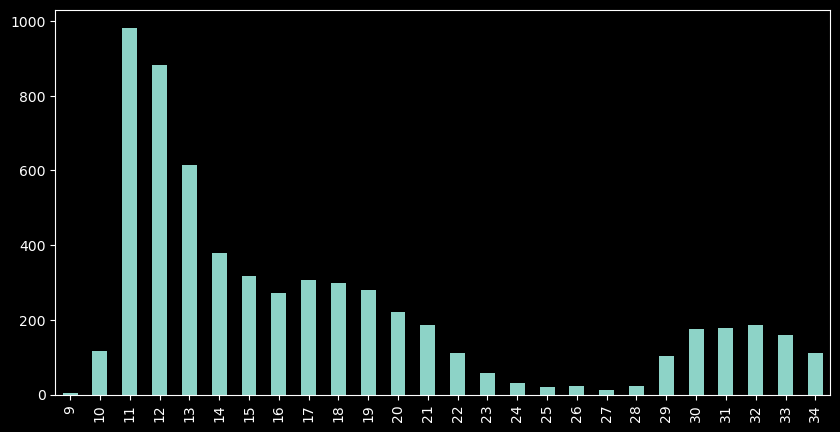

In [6]:
# Plot a bar chart for number of tweets for each hour
tweets["hour"].value_counts().sort_index().plot(kind="bar", figsize=(10, 5))
plt.show()

In [7]:
# Remove null longitude and latitude values
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
    (tweets.latitude > 42.33278)
    & (tweets.latitude < 51.08917)
    & (tweets.longitude > -4.795556)
    & (tweets.longitude < 8.230556)
]

# Set preprocessor options
p.set_options(p.OPT.URL)

# Remove URLs from the tweets
tweets['text'] = tweets['text'].apply(lambda x: p.clean(x))

# Set index to id for easy matching
# ! Verify_integrity=False is required because of duplicate ids
tweets.set_index('id', inplace=True, verify_integrity=False)

print(f"Size of full dataset: {len(tweets)}")

Size of full dataset: 5193


In [8]:
# Bounding box
bbox = (
    tweets.longitude.min(),
    tweets.longitude.max(),
    tweets.latitude.min(),
    tweets.latitude.max(),
)

# Center of the bounding box
center = (bbox[2] + (bbox[3] - bbox[2]) / 2, bbox[0] + (bbox[1] - bbox[0]) / 2)

In [9]:
# Map points with folium
map = folium.Map(location=[center[0], center[1]], zoom_start=6)

for index, row in tweets.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=1,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
    ).add_to(map)

In [10]:
map

(42.446666666667, 50.95)

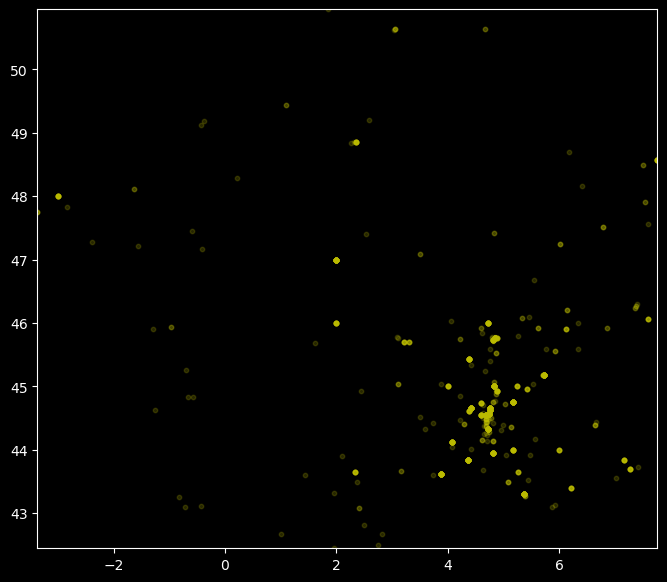

In [11]:
fig, ax = plt.subplots(figsize=(8, 7))
ax.scatter(tweets.longitude, tweets.latitude, zorder=1, alpha=0.2, c="y", s=10)
ax.set_xlim(bbox[0], bbox[1])
ax.set_ylim(bbox[2], bbox[3])